<table width="100%" style="border:none">
  <tr>
    <td valign="top">
      <h1>GTEx RNAseq Preprocessing</h1>
      <ul>
<li>Author: Jeremy Yang
<li>Based on R code by Oleg Ursu.
<li>Clean, tidy, reshape RNAseq expression data.
<li>Compute tissue specificity index (Yanai et al., 2004).
<li>Save files for downstream SABV expression profile analytics.
<li>[About Colaboratory](https://research.google.com/colaboratory/faq.html).
      </ul>
    </td>
    <td align="right">
        <p>NIH Data Commons: Team Helium</p>
<img style="float:right" width="100" src="https://avatars2.githubusercontent.com/u/33356654?s=200&v=4" alt="HeliumDataCommons Logo" />
    </td>
  </tr>
  </table>
 

In [76]:
import sys,os,re,time,io
import urllib.request
import google.colab
import numpy,scipy
import pandas
print('Python: %s\nPandas: %s'%(sys.version,pandas.__version__))

Python: 3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]
Pandas: 0.22.0


### Upload subjects datafile:
(GTEx_v7_Annotations_SubjectPhenotypesDS.txt)

In [2]:
print('Upload GTEx Subjects datafile: ')
uploaded = google.colab.files.upload()
fn = list(uploaded.keys())[0]
print('Uploaded "{name}" with {length} bytes'.format(name=fn, length=len(uploaded[fn])))
subjects = pandas.read_csv(io.StringIO(uploaded[fn].decode('utf8')), sep='\t', index_col='SUBJID')
print("dataset nrows: %d ; ncols: %d:"%(subjects.shape[0],subjects.shape[1]), file=sys.stderr)

Upload GTEx Subjects datafile: 


Saving GTEx_v7_Annotations_SubjectPhenotypesDS.txt to GTEx_v7_Annotations_SubjectPhenotypesDS.txt
Uploaded "GTEx_v7_Annotations_SubjectPhenotypesDS.txt" with 15485 bytes


dataset nrows: 752 ; ncols: 3:


In [3]:
subjects.head()

,SEX,AGE,DTHHRDY
SUBJID,,,
GTEX-1117F,2,60-69,4.0
GTEX-111CU,1,50-59,0.0
GTEX-111FC,1,60-69,1.0
GTEX-111VG,1,60-69,3.0
GTEX-111YS,1,60-69,0.0


In [4]:
subjects.AGE.value_counts().sort_index()

20-29     58
30-39     53
40-49    124
50-59    253
60-69    241
70-79     23
Name: AGE, dtype: int64

### Keep only healthier subjects: 
(DTHHRDY = 4-point Hardy Scale Death Classification.)

In [5]:
print("Subjects with Hardy score > 2 or NA: %d (removing)"%(subjects.query('DTHHRDY > 2').shape[0]), file=sys.stderr)
subjects = subjects.query('DTHHRDY <= 2')
print("dataset ncols: %d ; nrows: %d:"%(subjects.shape[0],subjects.shape[1]), file=sys.stderr)
subjects.DTHHRDY.value_counts(sort=True, dropna=False).sort_index()

Subjects with Hardy score > 2 or NA: 124 (removing)
dataset ncols: 609 ; nrows: 3:


0.0    390
1.0     29
2.0    190
Name: DTHHRDY, dtype: int64

### Upload samples datafile:
(GTEx_v7_Annotations_SampleAttributesDS.txt)

In [6]:
print('Upload GTEx Samples datafile: ')
uploaded = google.colab.files.upload()
fn = list(uploaded.keys())[0]
print('Uploaded "{name}" with {length} bytes'.format(name=fn, length=len(uploaded[fn])))
samples = pandas.read_csv(io.StringIO(uploaded[fn].decode('utf8')), sep='\t', index_col='SAMPID')
samples = samples[['SMATSSCR', 'SMTS', 'SMTSD']]
print("dataset nrows: %d ; ncols: %d:"%(samples.shape[0],samples.shape[1]), file=sys.stderr)

Upload GTEx Samples datafile: 


Saving GTEx_v7_Annotations_SampleAttributesDS.txt to GTEx_v7_Annotations_SampleAttributesDS.txt
Uploaded "GTEx_v7_Annotations_SampleAttributesDS.txt" with 8281415 bytes


dataset nrows: 15598 ; ncols: 3:


SUBJID is first two hyphen-delimted fields of SAMPID.

In [7]:
samples['SUBJID'] = samples.index
samples['SUBJID'] = samples.SUBJID.str.extract('^([^-]+-[^-]+)-', expand=True)

In [8]:
samples.head()

,SMATSSCR,SMTS,SMTSD,SUBJID
SAMPID,,,,
GTEX-1117F-0003-SM-58Q7G,NaN,Blood,Whole Blood,GTEX-1117F
GTEX-1117F-0003-SM-5DWSB,NaN,Blood,Whole Blood,GTEX-1117F
GTEX-1117F-0003-SM-6WBT7,NaN,Blood,Whole Blood,GTEX-1117F
GTEX-1117F-0226-SM-5GZZ7,0.0,Adipose Tissue,Adipose - Subcutaneous,GTEX-1117F
GTEX-1117F-0426-SM-5EGHI,0.0,Muscle,Muscle - Skeletal,GTEX-1117F


### MERGE samples and subjects:

In [9]:
samples = pandas.merge(samples, subjects, how='inner', left_on='SUBJID', right_index=True)
samples.head()

,SMATSSCR,SMTS,SMTSD,SUBJID,SEX,AGE,DTHHRDY
SAMPID,,,,,,,
GTEX-111CU-0003-SM-58Q95,NaN,Blood,Whole Blood,GTEX-111CU,1,50-59,0.0
GTEX-111CU-0003-SM-5DWTR,NaN,Blood,Whole Blood,GTEX-111CU,1,50-59,0.0
GTEX-111CU-0003-SM-6WBUD,NaN,Blood,Whole Blood,GTEX-111CU,1,50-59,0.0
GTEX-111CU-0126-SM-5GZWZ,0.0,Adrenal Gland,Adrenal Gland,GTEX-111CU,1,50-59,0.0
GTEX-111CU-0226-SM-5GZXC,0.0,Thyroid,Thyroid,GTEX-111CU,1,50-59,0.0


### Clean & tidy cols. Remove samples with high degree of autolysis (self-digestion).

In [10]:
samples.dropna(how='any', inplace=True)
print(samples.shape)
samples.SEX = samples.SEX.apply(lambda x: 'female' if x==2 else 'male' if x==1 else None)
samples.SEX.value_counts().sort_index()

(9279, 7)


female    3323
male      5956
Name: SEX, dtype: int64

In [11]:
samples = samples[samples.SMATSSCR < 2]
print(samples.shape)

(8422, 7)


In [12]:
samples.loc[(samples.SMTS.str.strip() == '') & samples.SMTSD.str.startswith("Skin -"), 'SMTS'] = 'Skin'

In [13]:
(samples.SMTS+" : "+samples.SMTSD).value_counts().sort_index()

Adipose Tissue : Adipose - Subcutaneous               430
Adipose Tissue : Adipose - Visceral (Omentum)         315
Adrenal Gland : Adrenal Gland                         159
Bladder : Bladder                                       8
Blood Vessel : Artery - Aorta                         274
Blood Vessel : Artery - Coronary                      161
Blood Vessel : Artery - Tibial                        452
Brain : Brain - Cerebellum                            107
Brain : Brain - Cortex                                 96
Breast : Breast - Mammary Tissue                      250
Cervix Uteri : Cervix - Ectocervix                      5
Cervix Uteri : Cervix - Endocervix                      3
Colon : Colon - Sigmoid                               193
Colon : Colon - Transverse                            186
Esophagus : Esophagus - Gastroesophageal Junction     240
Esophagus : Esophagus - Mucosa                        370
Esophagus : Esophagus - Muscularis                    358
Fallopian Tube

### READ GENE TPMs (full or demo subset)
Full file is ~56k rows, 2.6GB uncompressed.  Demo ~1k rows.

*   GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz
*   GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm_demo.gct.gz


In [21]:
print('Upload GTEx RNAseq TPM datafile: ')
t0 = time.time()
uploaded = google.colab.files.upload()
fn = list(uploaded.keys())[0]
print('Uploaded "{name}" with {length} bytes'.format(name=fn, length=len(uploaded[fn])))
rnaseq = pandas.read_table(io.BytesIO(uploaded[fn]), compression='gzip', sep='\t', skiprows=2)
print("dataset nrows: %d ; ncols: %d:"%(rnaseq.shape[0],rnaseq.shape[1]), file=sys.stderr)
print("Elapsed: %ds"%(time.time()-t0))

Upload GTEx RNAseq TPM datafile: 


Saving GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm_demo.gct.gz to GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm_demo.gct (1).gz
Uploaded "GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm_demo.gct.gz" with 16568044 bytes
Elapsed: 68s


dataset nrows: 1046 ; ncols: 11690:


In [22]:
rnaseq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Columns: 11690 entries, Name to GTEX-ZXG5-0005-SM-57WCN
dtypes: float64(11688), object(2)
memory usage: 93.3+ MB


In [23]:
rnaseq = rnaseq.drop(columns=['Description'])
rnaseq = rnaseq.rename(columns={'Name':'ENSG'})
rnaseq.columns

Index(['ENSG', 'GTEX-1117F-0226-SM-5GZZ7', 'GTEX-111CU-1826-SM-5GZYN',
       'GTEX-111FC-0226-SM-5N9B8', 'GTEX-111VG-2326-SM-5N9BK',
       'GTEX-111YS-2426-SM-5GZZQ', 'GTEX-1122O-2026-SM-5NQ91',
       'GTEX-1128S-2126-SM-5H12U', 'GTEX-113IC-0226-SM-5HL5C',
       'GTEX-117YX-2226-SM-5EGJJ',
       ...
       'GTEX-ZVE2-0006-SM-51MRW', 'GTEX-ZVP2-0005-SM-51MRK',
       'GTEX-ZVT2-0005-SM-57WBW', 'GTEX-ZVT3-0006-SM-51MT9',
       'GTEX-ZVT4-0006-SM-57WB8', 'GTEX-ZVTK-0006-SM-57WBK',
       'GTEX-ZVZP-0006-SM-51MSW', 'GTEX-ZVZQ-0006-SM-51MR8',
       'GTEX-ZXES-0005-SM-57WCB', 'GTEX-ZXG5-0005-SM-57WCN'],
      dtype='object', length=11689)

### MELT: One row per ENSG+SAMPID+TPM triplet:
Easier to handle but ~3x storage.

In [24]:
rnaseq = rnaseq.melt(id_vars = "ENSG", var_name = "SAMPID", value_name = "TPM")

In [25]:
rnaseq.head()

,ENSG,SAMPID,TPM
0,ENSG00000116198.8,GTEX-1117F-0226-SM-5GZZ7,11.19
1,ENSG00000221083.1,GTEX-1117F-0226-SM-5GZZ7,0.00
2,ENSG00000201725.1,GTEX-1117F-0226-SM-5GZZ7,0.00
3,ENSG00000049239.8,GTEX-1117F-0226-SM-5GZZ7,86.30
4,ENSG00000201746.1,GTEX-1117F-0226-SM-5GZZ7,0.00


In [26]:
rnaseq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12225648 entries, 0 to 12225647
Data columns (total 3 columns):
ENSG      object
SAMPID    object
TPM       float64
dtypes: float64(1), object(2)
memory usage: 279.8+ MB


### Read and merge gene symbols.

In [160]:
print('Upload Biomart ENSG2NCBI genes datafile: ')
uploaded = google.colab.files.upload()
fn = list(uploaded.keys())[0]
print('Uploaded "{name}" with {length} bytes'.format(name=fn, length=len(uploaded[fn])))
genes = pandas.read_csv(io.StringIO(uploaded[fn].decode('utf8')), sep='\t', usecols=[1,2,3], na_values=[''], dtype={2:str})
genes.columns = ['ENSG','NCBI','HGNC']
genes.dropna(inplace=True)

Upload ENSG2NCBI genes datafile: 


Saving biomart_ENSG2NCBI.tsv to biomart_ENSG2NCBI (5).tsv
Uploaded "biomart_ENSG2NCBI.tsv" with 2786143 bytes


,ENSG,NCBI,HGNC
1,ENSG00000211459.2,4549,MT-RNR1
3,ENSG00000210082.2,4550,MT-RNR2
5,ENSG00000198888.2,4535,MT-ND1
9,ENSG00000198763.3,4536,MT-ND2
15,ENSG00000198804.2,4512,MT-CO1


In [161]:
genes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27486 entries, 1 to 64717
Data columns (total 3 columns):
ENSG    27486 non-null object
NCBI    27486 non-null object
HGNC    27486 non-null object
dtypes: object(3)
memory usage: 858.9+ KB


In [162]:
rnaseq = pandas.merge(genes, rnaseq, on='ENSG', how='inner')
rnaseq.head()

,ENSG,NCBI,HGNC,SMTSD,ENSG_x,SAMPID,TPM,SMATSSCR,SMTS,SMTSD_x,SUBJID,SEX,AGE,DTHHRDY,max_tpm_0,ENSG_y,SMTSD_y
0,ENSG00000136999.4,4856,NOV,Adipose - Subcutaneous,ENSG00000136999.4,GTEX-111CU-1826-SM-5GZYN,5.191,0.0,Adipose Tissue,Adipose - Subcutaneous,GTEX-111CU,male,50-59,0.0,False,1,1
1,ENSG00000136999.4,4856,NOV,Adipose - Subcutaneous,ENSG00000136999.4,GTEX-111YS-2426-SM-5GZZQ,6.857,0.0,Adipose Tissue,Adipose - Subcutaneous,GTEX-111YS,male,60-69,0.0,False,1,1
2,ENSG00000136999.4,4856,NOV,Adipose - Subcutaneous,ENSG00000136999.4,GTEX-1122O-2026-SM-5NQ91,6.389,0.0,Adipose Tissue,Adipose - Subcutaneous,GTEX-1122O,female,60-69,0.0,False,1,1
3,ENSG00000136999.4,4856,NOV,Adipose - Subcutaneous,ENSG00000136999.4,GTEX-1128S-2126-SM-5H12U,10.150,0.0,Adipose Tissue,Adipose - Subcutaneous,GTEX-1128S,female,60-69,2.0,False,1,1
4,ENSG00000136999.4,4856,NOV,Adipose - Subcutaneous,ENSG00000136999.4,GTEX-117YX-2226-SM-5EGJJ,6.956,0.0,Adipose Tissue,Adipose - Subcutaneous,GTEX-117YX,male,50-59,0.0,False,1,1


### Remove genes in pseudoautosomal regions (PAR) of chromosome Y ("ENSGR").

In [29]:
n_ensgr = rnaseq.ENSG.str.startswith('ENSGR').sum()
print('ENSGR gene TPMs: %d (%.2f%%)'%(n_ensgr,100*n_ensgr/rnaseq.shape[0]))

ENSGR gene TPMs: 23376 (0.19%)


In [30]:
rnaseq = rnaseq[~rnaseq.ENSG.str.startswith('ENSGR')]

### Merge with samples:

In [31]:
rnaseq = pandas.merge(rnaseq, samples, how="inner", left_on="SAMPID", right_index=True)

In [32]:
rnaseq.head()

,ENSG,SAMPID,TPM,SMATSSCR,SMTS,SMTSD,SUBJID,SEX,AGE,DTHHRDY
1046,ENSG00000116198.8,GTEX-111CU-1826-SM-5GZYN,11.0600,0.0,Adipose Tissue,Adipose - Subcutaneous,GTEX-111CU,male,50-59,0.0
1047,ENSG00000221083.1,GTEX-111CU-1826-SM-5GZYN,0.0000,0.0,Adipose Tissue,Adipose - Subcutaneous,GTEX-111CU,male,50-59,0.0
1048,ENSG00000201725.1,GTEX-111CU-1826-SM-5GZYN,0.4618,0.0,Adipose Tissue,Adipose - Subcutaneous,GTEX-111CU,male,50-59,0.0
1049,ENSG00000049239.8,GTEX-111CU-1826-SM-5GZYN,61.9000,0.0,Adipose Tissue,Adipose - Subcutaneous,GTEX-111CU,male,50-59,0.0
1050,ENSG00000201746.1,GTEX-111CU-1826-SM-5GZYN,0.0000,0.0,Adipose Tissue,Adipose - Subcutaneous,GTEX-111CU,male,50-59,0.0




```
# This is formatted as code
```

### Remove data for gene-tissue pairs with all zero expression.

In [97]:
max_tpm_0 = (rnaseq[['ENSG', 'SMTSD', 'TPM']].groupby(by=['ENSG','SMTSD'], as_index=True).max() == 0).rename(columns={'TPM':'max_tpm_0'})
print(max_tpm_0.max_tpm_0.value_counts())
rnaseq = pandas.merge(rnaseq, max_tpm_0, left_on=['ENSG', 'SMTSD'], right_index=True)
rnaseq = rnaseq[~rnaseq['max_tpm_0']]
rnaseq.drop(columns=['max_tpm_0'], inplace=True)

                                                max_tpm_0
ENSG              SMTSD                                  
ENSG00000004975.7 Adipose - Subcutaneous            False
                  Adipose - Visceral (Omentum)      False
                  Adrenal Gland                     False
                  Artery - Aorta                    False
                  Artery - Coronary                 False
False    35734
True      4982
Name: max_tpm_0, dtype: int64


### Remove data for gene-tissue pairs not present in both sexes.

In [99]:
sex_count = (rnaseq[['ENSG', 'SMTSD', 'SEX']].groupby(by=['ENSG','SMTSD'], as_index=True).nunique()).rename(columns={'SEX':'sex_count'})
print(sex_count.sex_count.value_counts())
rnaseq = pandas.merge(rnaseq, sex_count, left_on=['ENSG', 'SMTSD'], right_index=True)
rnaseq = rnaseq[rnaseq['sex_count'] == 2]
rnaseq.drop(columns=['sex_count'], inplace=True)

2    28974
1     6760
Name: sex_count, dtype: int64


### Compute median TPM by gene+tissue:

In [100]:
rnaseq_med = rnaseq[['ENSG', 'SMTSD', 'TPM']].groupby(by=['ENSG','SMTSD'], as_index=False).median()
print("Unique counts: genes: %d ; tissues: %d ; gene-tissue pairs: %d"%(rnaseq_med.ENSG.nunique(), rnaseq_med.SMTSD.nunique(), rnaseq_med.shape[0]))
rnaseq_med.head()

Unique counts: genes: 1032 ; tissues: 31 ; gene-tissue pairs: 28974


,ENSG,SMTSD,TPM
0,ENSG00000004975.7,Adipose - Subcutaneous,31.050
1,ENSG00000004975.7,Adipose - Visceral (Omentum),21.140
2,ENSG00000004975.7,Adrenal Gland,30.710
3,ENSG00000004975.7,Artery - Aorta,33.895
4,ENSG00000004975.7,Artery - Coronary,30.290


In [0]:
rnaseq_med.to_csv('rnaseq_med.tsv', sep='\t')
google.colab.files.download('rnaseq_med.tsv')

In [101]:
rnaseq_med.TPM.describe()

count    28974.000000
mean        12.176161
std         92.147086
min          0.000000
25%          0.000000
50%          0.079800
75%          2.737125
max       5006.000000
Name: TPM, dtype: float64

### LOG10(TPM+1) useful transformation.

In [102]:
rnaseq_med['LOG_TPM'] = rnaseq_med.TPM.apply(lambda x: numpy.log10(x+1))

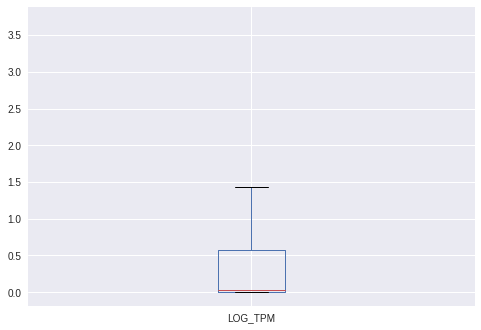

In [103]:
rnaseq_med.LOG_TPM.plot(kind='box')

### Compute tissue specificity index (Yanai et al., 2004).

> ## $ \tau = \frac{\sum_{i=0}^N (1 - x_i)}{N - 1} $

> * N = number of tissues
> * x = expression profile component normalized by the maximal component value

Validate with example vector from paper.  Should be 0.95.



In [104]:
def TAU(X):
  N = len(X)
  xmax = max(X)
  if xmax==0: return(0.0)
  tau = 0.0
  for x in X:
    tau += (1 - x/xmax)
  tau /= (N - 1)
  return(tau)
print('%.2f'%TAU([0,8,0,0,0,2,0,2,0,0,0,0]))

0.95


In [105]:
rnaseq_tau = rnaseq_med.groupby(['ENSG']).TPM.agg(TAU)
rnaseq_tau = pandas.DataFrame(rnaseq_tau).rename(columns={'TPM':'TAU'})
rnaseq_tau.head()

,TAU
ENSG,
ENSG00000004975.7,0.410932
ENSG00000008086.6,0.631277
ENSG00000009950.11,0.929331
ENSG00000012048.15,0.712469
ENSG00000014138.4,0.568580


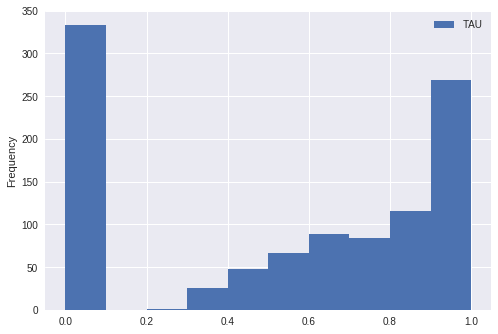

In [106]:
rnaseq_tau.plot(kind='hist')

### Assign gene-tissue rank (quantile of median) among tissues.
Low-Med-High cutoff quantiles: .25 and .75.  These ranks measure, for a given gene, relative tissue expression from the gene-tissue TPMs.

In [123]:
def GTRanks(rnaseq, tpm_col):
  tpm_rank = pandas.Series(dtype="float", index=range(rnaseq.shape[0]))
  for i in rnaseq.index:
    ensg = rnaseq.ENSG[i]
    val_this = rnaseq[tpm_col][i]
    vals_ensg = rnaseq[tpm_col][rnaseq.ENSG==ensg]
    vals_ensg = vals_ensg.sort_values().reset_index(drop=True)
    j = vals_ensg[vals_ensg == val_this].index[0]
    tpm_rank.iloc[i] = j/vals_ensg.size 

  rnaseq[tpm_col+'_RANK'] = tpm_rank
  return(rnaseq)

In [108]:
rnaseq_med.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28974 entries, 0 to 28973
Data columns (total 4 columns):
ENSG       28974 non-null object
SMTSD      28974 non-null object
TPM        28974 non-null float64
LOG_TPM    28974 non-null float64
dtypes: float64(2), object(2)
memory usage: 1.1+ MB


In [124]:
t0 = time.time()
rnaseq_level = GTRanks(rnaseq_med.copy(), 'TPM')
print("Elapsed: %ds"%(time.time()-t0))
rnaseq_level.head()

Elapsed: 98s


,ENSG,SMTSD,TPM,LOG_TPM,TPM_RANK,LEVEL,AGE,SEX
0,ENSG00000004975.7,Adipose - Subcutaneous,31.050,1.505828,0.548387,Medium,ALL,ALL
1,ENSG00000004975.7,Adipose - Visceral (Omentum),21.140,1.345178,0.258065,Medium,ALL,ALL
2,ENSG00000004975.7,Adrenal Gland,30.710,1.501196,0.483871,Medium,ALL,ALL
3,ENSG00000004975.7,Artery - Aorta,33.895,1.542763,0.612903,Medium,ALL,ALL
4,ENSG00000004975.7,Artery - Coronary,30.290,1.495406,0.419355,Medium,ALL,ALL


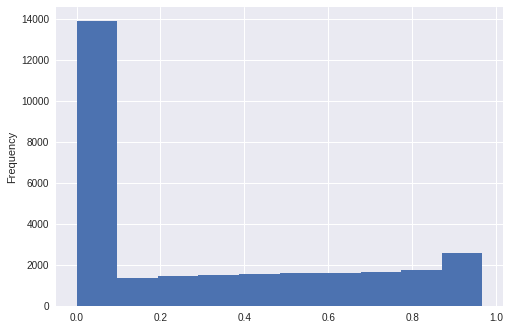

In [135]:
rnaseq_level.TPM_RANK.plot(kind='hist')

In [136]:
rnaseq_level.describe()

,TPM,LOG_TPM,TPM_RANK
count,28974.000000,28974.000000,28974.000000
mean,12.176161,0.373786,0.292579
std,92.147086,0.589962,0.335997
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.079800,0.033343,0.129032
75%,2.737125,0.572538,0.580645
max,5006.000000,3.699578,0.967742


In [0]:
rnaseq_level.to_csv('rnaseq_level.tsv', sep='\t')
google.colab.files.download('rnaseq_level.tsv')

In [137]:
rnaseq_level['LEVEL'] = rnaseq_level.TPM_RANK.apply(lambda x: 'Not detected' if x==0 else 'Low' if x<.25 else 'Medium' if x<.75 else 'High')
rnaseq_level['AGE'] = 'ALL'
rnaseq_level['SEX'] = 'ALL'
rnaseq_level.head()

,ENSG,SMTSD,TPM,LOG_TPM,TPM_RANK,LEVEL,AGE,SEX
0,ENSG00000004975.7,Adipose - Subcutaneous,31.050,1.505828,0.548387,Medium,ALL,ALL
1,ENSG00000004975.7,Adipose - Visceral (Omentum),21.140,1.345178,0.258065,Medium,ALL,ALL
2,ENSG00000004975.7,Adrenal Gland,30.710,1.501196,0.483871,Medium,ALL,ALL
3,ENSG00000004975.7,Artery - Aorta,33.895,1.542763,0.612903,Medium,ALL,ALL
4,ENSG00000004975.7,Artery - Coronary,30.290,1.495406,0.419355,Medium,ALL,ALL


In [138]:
rnaseq_level.LEVEL.value_counts().sort_index()

High             4350
Low              3199
Medium           8404
Not detected    13021
Name: LEVEL, dtype: int64

### Compute median TPM by gene+tissue+SEX:

In [139]:
rnaseq_med_sex = rnaseq[['ENSG', 'SMTSD', 'SEX', 'TPM']].groupby(by=['ENSG','SMTSD','SEX'], as_index=False).median()
print(rnaseq_med_sex.shape)
rnaseq_med_sex.head()

(57948, 4)


,ENSG,SMTSD,SEX,TPM
0,ENSG00000004975.7,Adipose - Subcutaneous,female,28.920
1,ENSG00000004975.7,Adipose - Subcutaneous,male,32.260
2,ENSG00000004975.7,Adipose - Visceral (Omentum),female,19.830
3,ENSG00000004975.7,Adipose - Visceral (Omentum),male,22.275
4,ENSG00000004975.7,Adrenal Gland,female,30.430


### Combine rows into one row per gene+tissue, cols for M and F TPM.

In [140]:
rnaseq_med_sex_f = rnaseq_med_sex.loc[rnaseq_med_sex['SEX'] == 'female']
rnaseq_med_sex_f = rnaseq_med_sex_f[['ENSG', 'SMTSD', 'TPM']].rename(columns={'TPM':'TPM_F'})
rnaseq_med_sex_m = rnaseq_med_sex.loc[rnaseq_med_sex['SEX'] == 'male']
rnaseq_med_sex_m = rnaseq_med_sex_m[['ENSG', 'SMTSD', 'TPM']].rename(columns={'TPM':'TPM_M'})
rnaseq_med_sex = pandas.merge(rnaseq_med_sex_f, rnaseq_med_sex_m, how='inner', on=['ENSG','SMTSD'])
rnaseq_med_sex.head()

,ENSG,SMTSD,TPM_F,TPM_M
0,ENSG00000004975.7,Adipose - Subcutaneous,28.92,32.260
1,ENSG00000004975.7,Adipose - Visceral (Omentum),19.83,22.275
2,ENSG00000004975.7,Adrenal Gland,30.43,31.255
3,ENSG00000004975.7,Artery - Aorta,32.55,34.550
4,ENSG00000004975.7,Artery - Coronary,29.04,31.280


In [141]:
t0 = time.time()
rnaseq_level_f = GTRanks(rnaseq_med_sex[['ENSG','SMTSD','TPM_F']].copy(), 'TPM_F')
print("Elapsed: %ds"%(time.time()-t0))
rnaseq_level_f['LEVEL_F'] = rnaseq_level_f.TPM_F_RANK.apply(lambda x: 'Not detected' if x==0 else 'Low' if x<.25 else 'Medium' if x<.75 else 'High')
rnaseq_level_f.head()

Elapsed: 99s


,ENSG,SMTSD,TPM_F,TPM_F_RANK,LEVEL_F
0,ENSG00000004975.7,Adipose - Subcutaneous,28.92,0.387097,Medium
1,ENSG00000004975.7,Adipose - Visceral (Omentum),19.83,0.225806,Low
2,ENSG00000004975.7,Adrenal Gland,30.43,0.483871,Medium
3,ENSG00000004975.7,Artery - Aorta,32.55,0.580645,Medium
4,ENSG00000004975.7,Artery - Coronary,29.04,0.451613,Medium


In [142]:
t0 = time.time()
rnaseq_level_m = GTRanks(rnaseq_med_sex[['ENSG','SMTSD','TPM_M']].copy(), 'TPM_M')
print("Elapsed: %ds"%(time.time()-t0))
rnaseq_level_m['LEVEL_M'] = rnaseq_level_m.TPM_M_RANK.apply(lambda x: 'Not detected' if x==0 else 'Low' if x<.25 else 'Medium' if x<.75 else 'High')
rnaseq_level_m.head()

Elapsed: 100s


,ENSG,SMTSD,TPM_M,TPM_M_RANK,LEVEL_M
0,ENSG00000004975.7,Adipose - Subcutaneous,32.260,0.580645,Medium
1,ENSG00000004975.7,Adipose - Visceral (Omentum),22.275,0.258065,Medium
2,ENSG00000004975.7,Adrenal Gland,31.255,0.483871,Medium
3,ENSG00000004975.7,Artery - Aorta,34.550,0.612903,Medium
4,ENSG00000004975.7,Artery - Coronary,31.280,0.516129,Medium


In [145]:
rnaseq_level = pandas.merge(rnaseq_level_f, rnaseq_level_m, on = ['ENSG','SMTSD'], how = 'inner')
rnaseq_level.head()

,ENSG,SMTSD,TPM_F,TPM_F_RANK,LEVEL_F,TPM_M,TPM_M_RANK,LEVEL_M
0,ENSG00000004975.7,Adipose - Subcutaneous,28.92,0.387097,Medium,32.260,0.580645,Medium
1,ENSG00000004975.7,Adipose - Visceral (Omentum),19.83,0.225806,Low,22.275,0.258065,Medium
2,ENSG00000004975.7,Adrenal Gland,30.43,0.483871,Medium,31.255,0.483871,Medium
3,ENSG00000004975.7,Artery - Aorta,32.55,0.580645,Medium,34.550,0.612903,Medium
4,ENSG00000004975.7,Artery - Coronary,29.04,0.451613,Medium,31.280,0.516129,Medium


### For each gene, compute sex difference via Wilcox test:
(Wilcoxon signed-rank test, with Wilcox treatment, discarding all zero-differences.)

In [146]:
wilcox = pandas.DataFrame({'ENSG':rnaseq_med_sex.ENSG.drop_duplicates().sort_values(), 'stat':None, 'pval':None}).reset_index(drop=True)

for i in range(wilcox.shape[0]):
  tpm_f_this = rnaseq_med_sex.TPM_F[rnaseq_level.ENSG == wilcox.ENSG[i]]
  tpm_m_this = rnaseq_med_sex.TPM_M[rnaseq_level.ENSG == wilcox.ENSG[i]]
  stat, pval = scipy.stats.wilcoxon(x=tpm_f_this, y=tpm_m_this, zero_method='wilcox')
  wilcox.stat.iloc[i] = stat
  wilcox.pval.iloc[i] = pval 
wilcox.head()

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2422: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se


,ENSG,pval,stat
0,ENSG00000004975.7,0.176324,179
1,ENSG00000008086.6,0.0547996,150
2,ENSG00000009950.11,0.216986,185
3,ENSG00000012048.15,0.056042,150.5
4,ENSG00000014138.4,0.0919302,162


### Combine rows into one row per gene+tissue, cols for M and F TPM.

### Log fold-change is log of ratio.

In [149]:
rnaseq_level['log2foldchange'] = ((rnaseq_level.TPM_F+1) / (rnaseq_level.TPM_M+1)).apply(lambda x: numpy.log2(max(x, 1/x)))
rnaseq_level.head()

,ENSG,SMTSD,TPM_F,TPM_F_RANK,LEVEL_F,TPM_M,TPM_M_RANK,LEVEL_M,log2foldchange
0,ENSG00000004975.7,Adipose - Subcutaneous,28.92,0.387097,Medium,32.260,0.580645,Medium,0.152678
1,ENSG00000004975.7,Adipose - Visceral (Omentum),19.83,0.225806,Low,22.275,0.258065,Medium,0.160118
2,ENSG00000004975.7,Adrenal Gland,30.43,0.483871,Medium,31.255,0.483871,Medium,0.037381
3,ENSG00000004975.7,Artery - Aorta,32.55,0.580645,Medium,34.550,0.612903,Medium,0.083537
4,ENSG00000004975.7,Artery - Coronary,29.04,0.451613,Medium,31.280,0.516129,Medium,0.103756


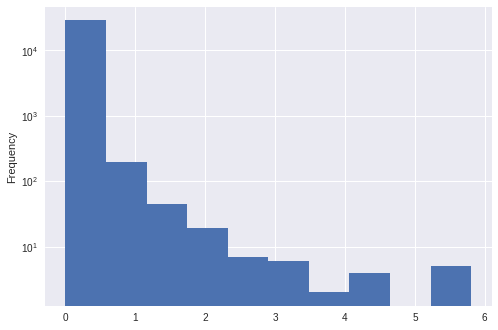

In [153]:
rnaseq_level.log2foldchange.plot(kind='hist', logy=True)